Version info
>v011 - deleted testing codes

>v013 - manipulating multiple beta(This version works properly)

>v021 - Version jump without missing value imputation, skipping v014~v018 because I'm tired out figuring out buggs.

Environment

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import pymc3 as pm
import scipy.optimize as so

import datetime as dt

#from pymc3 import Model, sample, find_MAP, summary
from pymc3 import NUTS, Metropolis, Slice
#from pymc3 import Normal, Uniform
#from scipy import optimize
#from pymc3 import traceplot

In [4]:
debug = False

In [3]:
debug = True

Loading and preprocessing barley data(explatory variables)

In [5]:
#Loading data file
#barley_raw = pd.read_csv('./data/barley_01.csv', sep=',', header=0, index_col=0)
barley_raw = pd.read_table('./data/barley_01.txt', sep='\t', header=0, index_col=0)

#Explorering data
if debug:
    barley_raw.head()
    barley_raw.info()

#Transposing
barley_t = barley_raw.transpose()
if debug:
    print(barley_t.iloc[0:5, 0:5])

# 39, 96, 116, 103 th DH lines removed for marker mapping(146 marker mappings)
# and also 33 th DH line should be removed for QTL analysis(145 lines)
barley = barley_t.drop(labels=barley_t.index[[39-1, 96-1, 116-1, 103-1, 33-1]])

barley.head()

#Imputed missing(-) to 1 temporarily, I'll use automatic imputation feature of PyMC
#[http://stronginference.com/missing-data-imputation.html]
barley.replace(['A', 'B', '-'], [0,1,0], inplace=True)

if debug:
    print(barley.ix[:6,10:20])

Loading and preprocessing heading data(response variable)

In [6]:
heading_raw = pd.read_table('./data/HED_01.txt', sep='\t', header=0, index_col=0)
heading_raw.replace([-9999.0, -9999], [float('NaN'), float('NaN')], inplace=True)
if debug:
    print(heading_raw.head())
    
# Averaging 'days to heading' over all environments for each line.
heading = heading_raw.mean(skipna=True)
if debug:
    heading.head()



Testing with multivariate beta

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta2
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta3
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta4
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta5
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta6
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta7
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta8
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta9
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta10
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta11
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta12
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta13
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta14
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta15
Assigned <class 'pymc3.st

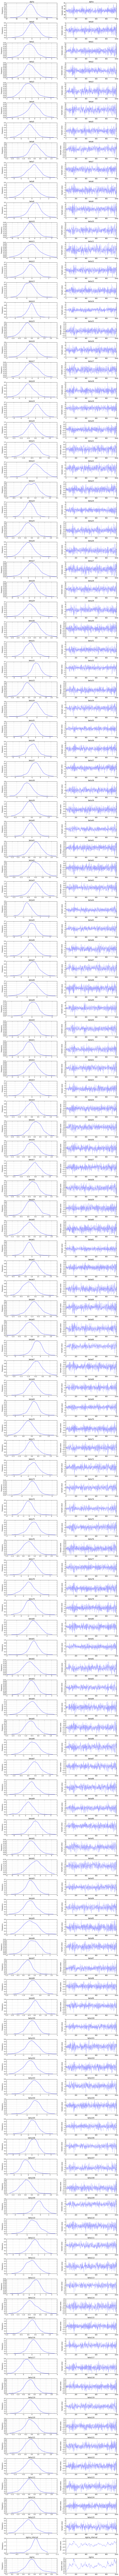

In [10]:
import datetime
a = datetime.datetime.now()



niter = 1000
beta = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    for i in range(num_p): # beta0 to betaN
        beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X.ix[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())

b = datetime.datetime.now()
c = b - a

Here we test multi beta with shape value

In [ ]:
import datetime
a = datetime.datetime.now()

num_n = 144 #max 144(total 145 rows)
num_p = 126  #max 126(total 127 columns)
X = barley.ix[:num_n,:num_p]
Y = heading.ix[:num_n]

niter = 1000
#beta = np.empty(num_p, dtype=object)
basic_model = pm.Model()
with basic_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=100, shape=1) # Intercept
    #for i in range(num_p): # beta0 to betaN
    #    beta[i] = pm.Normal('beta' + str(i), mu=0, sd=100, shape=1)
    beta = pm.Normal('beta', mu=0, sd=100, shape=num_p)
    sigma = pm.Uniform('sigma', lower=0, upper=20) # Std
    
    # Expected value of outcome
    mu = alpha
    for i in range(num_p):
        mu = mu + beta[i]*X.ix[:,i]
    
    # Likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=Y)
    
    # Obtaining starting values via MAP
    start = pm.find_MAP()
    
    #step = Metropolis()
    step = Slice()
    
    # Draw samples from posterior
    trace = pm.sample(niter, start=start, step=step, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)
    
    # Test code to check if procedure finished.
    print(dt.datetime.now().time())

b = datetime.datetime.now()
c = b - a

In [11]:
c.seconds / 60
# gpu, 1000 samples, w/  shape, NUTS : 19.466666666666665 minutes
# cpu, 1000 samples, w/  shape, NUTS : 20.083333333333332
# cpu, 1000 samples, w/o shape, NUTS : 73.66666666666667


73.66666666666667